# Part 3A: MNIST CNN with Keras (tf.keras)

_Author: Suyog Garg_, _Dated: 2025/11/18_



This notebook implements a compact **CNN** in **Keras** (the high‑level API that ships with TensorFlow).
It reports training curves and test metrics, and saves a small JSON for the comparison notebook.


The notebook also assumes you have already created and activated the conda environment for the tutorial (for example gw-ml-env) and that this notebook is running on that environment’s kernel.
The cell below will install the extra Python libraries needed for Part 3 (Keras, TensorFlow, PyTorch, scikit-learn, etc.) from the Part3_requirements.txt file in this repository. You only need to run it once per environment.

In [10]:
# Install Part 3 dependencies from the local requirements file
# Run this once per environment, at the start of Part 3.

import sys
import subprocess
from pathlib import Path

req_path = Path("Part3_requirements.txt")

if req_path.is_file():
    print(f"Installing packages from {req_path} using this interpreter:\n  {sys.executable}\n")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", str(req_path)])
    print("\nDone. You may need to restart the kernel if packages were upgraded.")
else:
    print("Could not find Part3_requirements.txt in the current directory.")
    print("Make sure you run this notebook from the tutorial repo root.")


Installing packages from Part3_requirements.txt using this interpreter:
  /opt/homebrew/anaconda3/envs/general/bin/python3


Done. You may need to restart the kernel if packages were upgraded.


## Environment
Use pip (Colab) or conda (local). The code detects CPU/GPU automatically.

In [11]:
import os, sys, time, json, pathlib
import numpy as np
import matplotlib.pyplot as plt
# Keras is part of TensorFlow
import tensorflow as tf
from tensorflow import keras
print("TensorFlow:", tf.__version__)
print("Keras API:", keras.__version__)
print("Devices:", tf.config.list_physical_devices())

TensorFlow: 2.20.0
Keras API: 3.12.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]



## Dataset & preprocessing

We use **MNIST** (28×28 grayscale digits, 10 classes). Input is normalized to `[0, 1]`
and reshaped to `(N, 28, 28, 1)` for CNNs. Labels are integers `0..9`.


In [12]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0
x_train = np.expand_dims(x_train, -1)  # (N,28,28,1)
x_test  = np.expand_dims(x_test, -1)

print("Train:", x_train.shape, y_train.shape, " Test:", x_test.shape, y_test.shape)

Train: (60000, 28, 28, 1) (60000,)  Test: (10000, 28, 28, 1) (10000,)


## Model
Simple ConvNet: `Conv(32)->Conv(64)->MaxPool->Dropout->Flatten->Dense(128)->Dense(10)`

In [4]:
from tensorflow.keras import layers, models

def build_model():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [13]:
import time
callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
t0=time.perf_counter()
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=5, batch_size=128, callbacks=callbacks, verbose=1)
train_time = time.perf_counter()-t0
print("Train time (s):", train_time)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.9931 - loss: 0.0205 - val_accuracy: 0.9902 - val_loss: 0.0375
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.9946 - loss: 0.0160 - val_accuracy: 0.9888 - val_loss: 0.0368
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9959 - loss: 0.0120 - val_accuracy: 0.9908 - val_loss: 0.0359
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9971 - loss: 0.0084 - val_accuracy: 0.9902 - val_loss: 0.0436
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9967 - loss: 0.0095 - val_accuracy: 0.9922 - val_loss: 0.0371
Train time (s): 125.71503745799419


## Curves

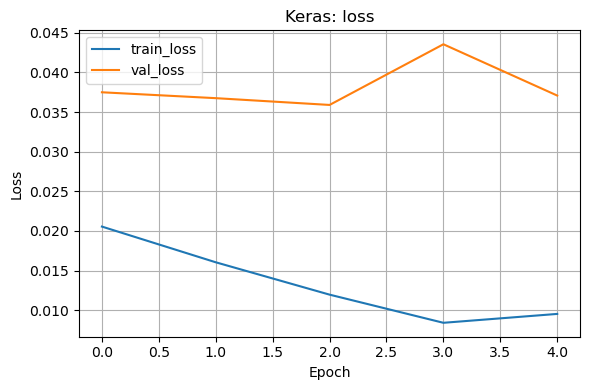

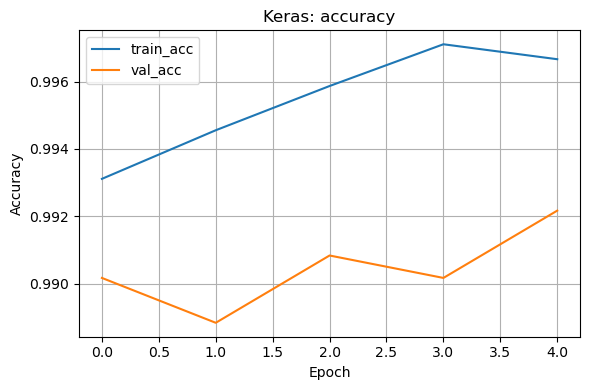

In [14]:
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.title("Keras: loss")
plt.tight_layout()
plt.savefig("artifacts/keras_loss.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.title("Keras: accuracy")
plt.tight_layout()
plt.savefig("artifacts/keras_acc.png", dpi=150)
plt.show()

## Evaluate & save metrics

In [7]:
# Utility: save artifacts (plots & metrics)
import os, json, pathlib, time
ART = pathlib.Path("artifacts")
ART.mkdir(exist_ok=True)

In [8]:
def save_metrics(name, **metrics):
    path = ART / f"{name}_metrics.json"
    with open(path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved:", path)

def effective_loc(*funcs):
    import inspect
    n = 0
    for f in funcs:
        try:
            src = inspect.getsource(f)
            for line in src.splitlines():
                s = line.strip()
                if s and not s.startswith("#"):
                    n += 1
        except Exception:
            pass
    return n

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
params = model.count_params()
save_metrics("keras", framework="keras", test_accuracy=float(test_acc), test_loss=float(test_loss),
             train_time_sec=float(train_time), params=int(params), epochs=int(len(hist.history["loss"])),
             device=str(tf.config.list_physical_devices("GPU") or tf.config.list_physical_devices("CPU")),
             effective_loc=int(effective_loc(build_model)))
model.save("artifacts/keras_mnist.keras")
print("Saved model and metrics to artifacts/")

Saved: artifacts/keras_metrics.json
Saved model and metrics to artifacts/
